In [1]:
import os
import sys
import glob
import random 
import util
import numpy as np
from random import shuffle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
import nibabel as nib
import nibabel.processing as proc
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
# from numpy import random

In [29]:
# Input image
root_src = "/home/local/VANDERBILT/kanakap/deepN4_data/inputs"
T1s = []
for files in glob.glob(root_src +'/*.nii.gz'):
    T1s.append(files)
T1s.sort()

# Target
root_out = "/home/local/VANDERBILT/kanakap/deepN4_data/labels"
N4_T1s = []
for files in glob.glob(root_out +'/*.nii.gz'):
    N4_T1s.append(files)
N4_T1s.sort()

In [3]:
rand = random.sample(range(1, 100), 7)
rand

[28, 64, 80, 90, 55, 35, 9]

In [2]:
rand = [28, 64, 80, 90, 55, 35, 9]
train_idx = rand[0:5]
val_idx = rand[5]
test_idx = rand[6]

In [37]:

rand = random.sample((range(1, 500)), 240)
rand
np.savetxt('rand_split2.txt',rand)

TypeError: random_sample() takes at most 1 positional argument (2 given)

In [70]:
train_idx = rand[0:100]
val_idx = rand[100:120]
test_idx = rand[120:140]

In [73]:
with open('train_100ds.csv', 'w') as f:
    for i in train_idx:
        f.write("%s,%s\n" % (N4_T1s[i],T1s[i]))
with open('val_100ds.csv', 'w') as f:
    for i in val_idx:
        f.write("%s,%s\n" % (N4_T1s[i],T1s[i]))
with open('test_100ds.csv', 'w') as f:
    for i in test_idx:
        f.write("%s,%s\n" % (N4_T1s[i],T1s[i]))

In [5]:
def plot_montage(few_files,ax):
    x = 0
    y = 0 
    for z in range(len(few_files)):
        image = nib.load(few_files[z]).get_fdata()
        #image = image[:,:,np.int32(image.shape[2] / 2)]
        image = image[:,:,np.int32(image.shape[2] / 1.7)]
        ax_image = np.squeeze(image)
        ax_image = np.rot90(ax_image,1)
        im = ax[x,y].imshow(ax_image, cmap='gray')
        ax[x,y].set_title(z)
        ax[x,y].axis('off')
        divider = make_axes_locatable(ax[x,y])
        c_ax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im , cax=c_ax)

        if y == 4:
            x += 1
        y += 1
        if y != 0 and y % 5 == 0:
            y = 0

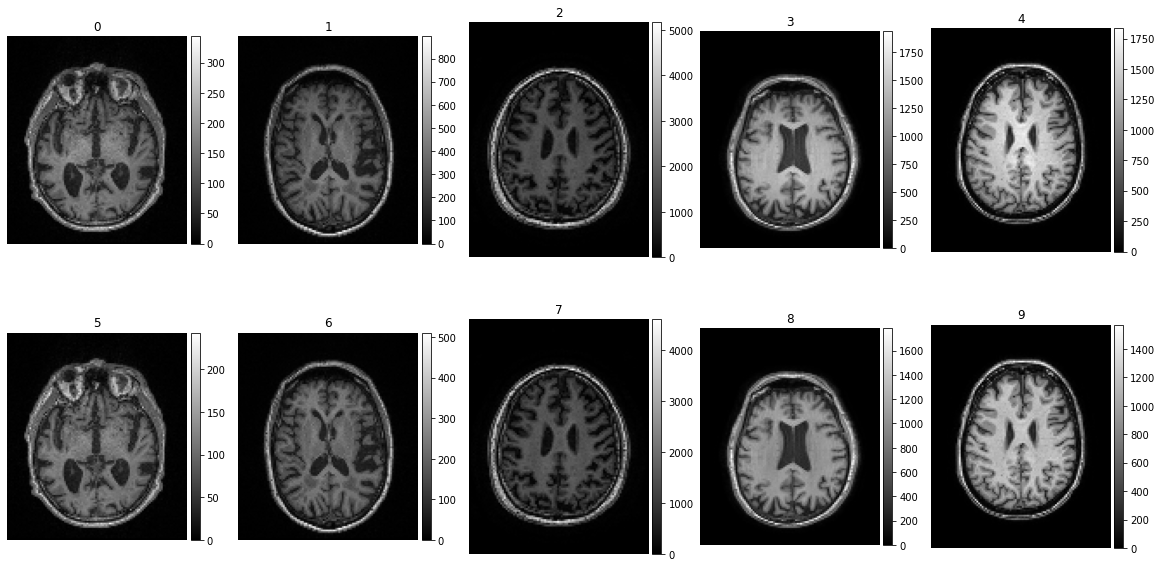

In [6]:
input_files = []
target_files = []

for i in train_idx:
    input_files.append(T1s[i])
for i in train_idx:
    target_files.append(N4_T1s[i])

fig, ax = plt.subplots(2,5,figsize=(20,10))
plot_montage(input_files + target_files,ax)

In [40]:
def pad(img, sz):
    tmp = np.zeros((sz, sz, sz))

    diff = int((sz-img.shape[0])/2)
    lx = max(diff,0)
    lX = min(img.shape[0]+diff,sz)

    diff = (img.shape[0]-sz) / 2
    rx = max(int(np.floor(diff)),0)
    rX = min(img.shape[0]-int(np.ceil(diff)),img.shape[0])

    diff = int((sz - img.shape[1]) / 2)
    ly = max(diff, 0)
    lY = min(img.shape[1] + diff, sz)

    diff = (img.shape[1] - sz) / 2
    ry = max(int(np.floor(diff)), 0)
    rY = min(img.shape[1] - int(np.ceil(diff)), img.shape[1])

    diff = int((sz - img.shape[2]) / 2)
    lz = max(diff, 0)
    lZ = min(img.shape[2] + diff, sz)

    diff = (img.shape[2] - sz) / 2
    rz = max(int(np.floor(diff)), 0)
    rZ = min(img.shape[2] - int(np.ceil(diff)), img.shape[2])

    tmp[lx:lX,ly:lY,lz:lZ] = img[rx:rX,ry:rY,rz:rZ]

    return tmp, [lx,lX,ly,lY,lz,lZ,rx,rX,ry,rY,rz,rZ]
    
def normalize_img( img, max_img, min_img, a_max, a_min):

    raw_img = (img - min_img)/(max_img - min_img)
    img = np.clip(raw_img, a_max=a_max, a_min=a_min)
    return img

def transform( img):
    x = random.randint(low=30, high=180)
    rotated = rotate(img, angle=x)
    flip = np.fliplr(rotated)
    return flip

In [56]:
# input_data = nib.load(input_files[0]).get_fdata()
# input_data, _ = pad(input_data, 128)
# inmax = np.percentile(input_data[np.nonzero(input_data)], 99.99)
# # print(inmax)
# input_data = normalize_img(input_data, inmax, 0, 1, 0)

In [58]:
# input_data = np.where(input_data<0,input_data,0.0)
# input_data = np.where(input_data>1,input_data,1.0)
# np.unique(input_data)

array([1.])

In [41]:
def load_data(image_file):
    input_data = nib.load(image_file).get_fdata()
    input_data, _ = pad(input_data, 128)
    inmax = np.percentile(input_data[np.nonzero(input_data)], 99.99)
    # print(inmax)
    input_data = normalize_img(input_data, inmax, 0, 1, 0)
    input_data = transform(input_data)
    return input_data


In [20]:
def plot_montage_data_load(few_files,ax):
    x = 0
    y = 0 
    for z in range(len(few_files)):
        # image = nib.load(few_files[z]).get_fdata()
        image = load_data(few_files[z])
        image = image[:,:,np.int32(image.shape[2] / 1.7)]
        ax_image = np.squeeze(image)
        ax_image = np.rot90(ax_image,1)
        im = ax[x,y].imshow(ax_image, cmap='gray')
        ax[x,y].set_title(z)
        ax[x,y].axis('off')
        divider = make_axes_locatable(ax[x,y])
        c_ax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im , cax=c_ax)
        if y == 4:
            x += 1
        y += 1
        if y != 0 and y % 5 == 0:
            y = 0

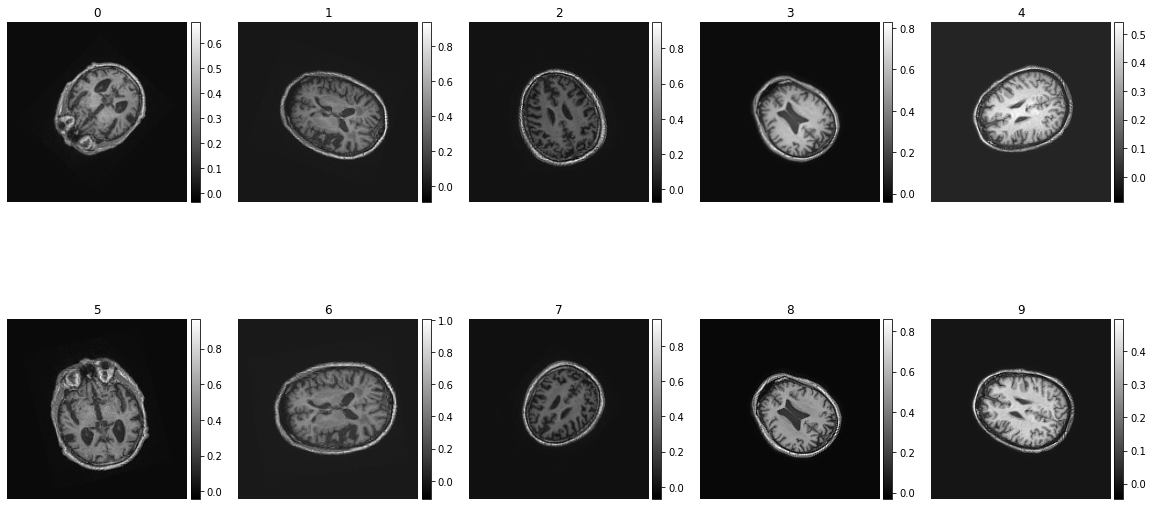

In [42]:
input_files = []
target_files = []

for i in train_idx:
    input_files.append(T1s[i])
for i in train_idx:
    target_files.append(N4_T1s[i])

fig, ax = plt.subplots(2,5,figsize=(20,10))
plot_montage_data_load(input_files + target_files,ax)

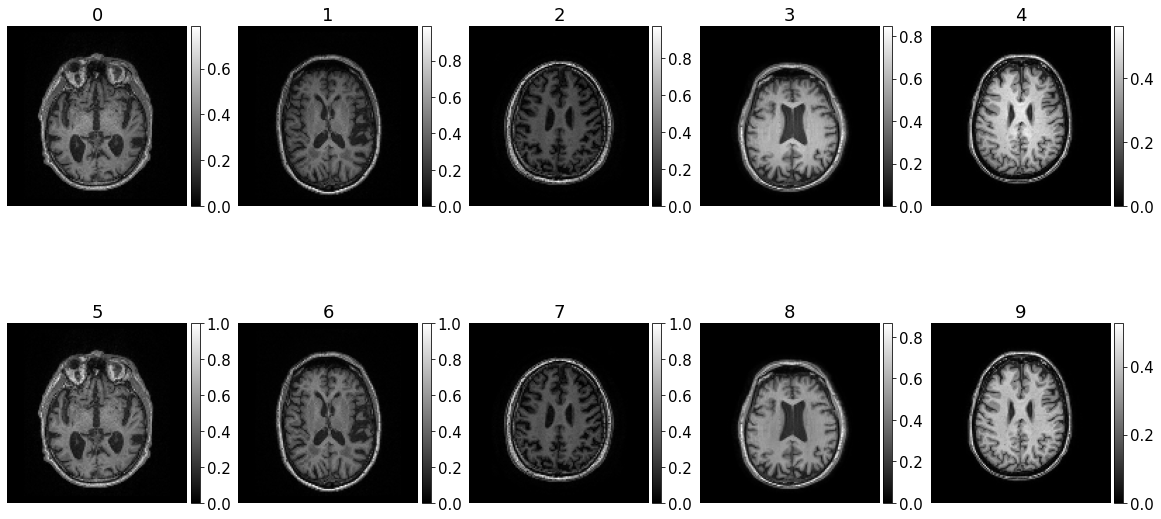

In [64]:
input_files = []
target_files = []

for i in train_idx:
    input_files.append(T1s[i])
for i in train_idx:
    target_files.append(N4_T1s[i])

fig, ax = plt.subplots(2,5,figsize=(20,10))
plot_montage_data_load(input_files + target_files,ax)

In [43]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_3dunet_100data.nii.gz').get_fdata()
pred = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_biasfield_100data.nii.gz').get_fdata()
estimated = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()

In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred0 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_img2imgMNI/pred_3dunet_100data.nii.gz').get_fdata()
estimated = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_img2imgMNI/pred_biasfield_100data.nii.gz').get_fdata()
pred = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()

In [92]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/labels/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
pred0 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/train_pred_3dunet_32c.nii.gz').get_fdata()
mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()

In [12]:
mask1 = mask1.astype(int)
eps = 1e-6
# input1 = np.where(mask1, input1, 0)
# target1 = np.where(mask1, target1, 0)
# pred0 = np.where(mask1, pred0, 0)
estimated_field = (target1 + eps)/(input1 + eps)
predicted_field = (pred0 + eps)/(input1 + eps)
estimated_field = np.where(mask1, estimated_field, 0)
predicted_field = np.where(mask1, predicted_field, 0)
estimated_field.shape

(99, 117, 95)

In [11]:
estimated_field = estimated_field[estimated_field != 0]
estimated_field.shape

(253050,)

In [16]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_3dunet_dividebias_native.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_biasfield_native.nii.gz').get_fdata()


In [12]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_logspace/pred_3dunet_logspace.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_logspace/pred_biasfield_logspace.nii.gz').get_fdata()


In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_auto/pred_3dunet_auto.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_auto/pred_biasfield_auto.nii.gz').get_fdata()


In [27]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_logsub_d100/pred_3dunet_logsub_d100.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_logsub_d100/pred_biasfield_logsub_d100.nii.gz').get_fdata()


In [20]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_logsub2/train_pred_3dunet_logsub2.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_logsub2/train_pred_biasfield_logsub2.nii.gz').get_fdata()

In [15]:
pred1.shape

(103, 128, 128)

/tmp/ipykernel_2612834/1094697356.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,4,1)


2.317595958709717


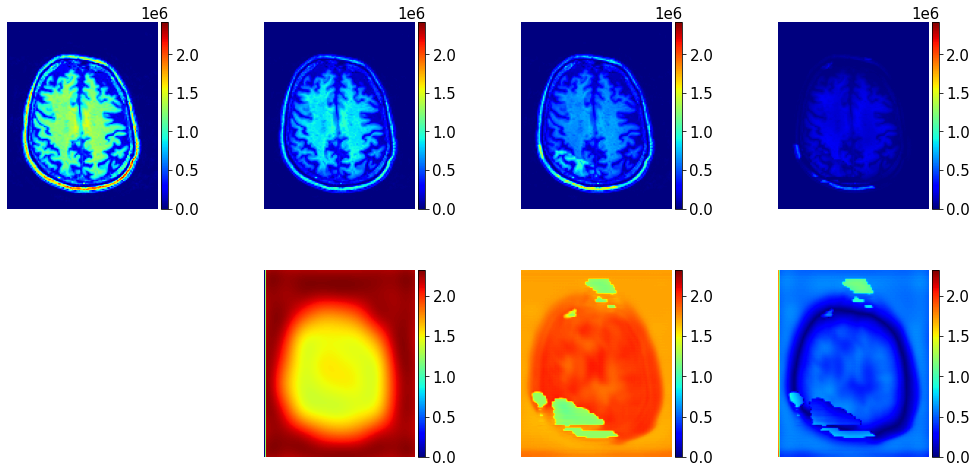

In [28]:
plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots(figsize=(18,8))

slice = input1
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(2,4,1)
plt.axis('off')
m = 0
M = np.max(slice)
im = plt.imshow(np.abs(slice),vmin=m, vmax=M,  cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = target1
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(2,4,2)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M, cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = pred1
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(2,4,3)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M,  cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = pred1 - target1
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(2,4,4)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M,  cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)


slice = estimated_field
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
m = 0
M = np.max(slice) 
print(np.max(slice))
plt.subplot(2,4,6)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M,  cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = predicted_field
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(2,4,7)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M,  cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = predicted_field - estimated_field
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(2,4,8)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M,  cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)
plt.subplots_adjust(wspace=0.1,hspace=0.33)


In [10]:
import math
def fun_rmse(a,b):   
    MSE = np.square(np.subtract(a,b)).mean()
    RMSE = math.sqrt(MSE)
    return RMSE

In [13]:
fun_rmse(target1,pred1)

41096.48398482717

In [12]:
fun_rmse(estimated_field,predicted_field)

0.9172468266364024

In [37]:
eps = 1e-6
slice = (target1 + eps)/(input1 + eps)

In [40]:
np.min(slice)

2.587008158204378e-12

In [4]:
import math
def fun_rmse(a,b):   
    MSE = np.square(np.subtract(a,b)).mean()
    RMSE = math.sqrt(MSE)
    return RMSE


In [10]:
inputmasked = np.where(mask1,input1,0)
targetmasked = np.where(mask1,target1,0)
predmasked = np.where(mask1,pred0,0)

print(fun_rmse(predmasked,targetmasked))

56336.92805231833


In [2]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred0 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_3dunet_100data.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_biasfield_100data.nii.gz').get_fdata()


In [12]:
fun_rmse(estimated_field,pred_field)

0.9172468266364024

In [10]:
import scipy.stats
estimated_field[np.isnan(estimated_field)] = 0
estimated_field[np.isinf(estimated_field)] = 0
pred_field[np.isnanee(pred_field)] = 0
pred_field[np.isinf(pred_field)] = 0


a = estimated_field.flatten()
b = pred_field.flatten()
scipy.stats.pearsonr(a,b)

(-0.0013240051626896537, 0.0854398693897565)

In [49]:
ref = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz')
nii = nib.Nifti1Image(estimated_field, affine=ref.affine, header=ref.header)
nib.save(nii, '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/estimated_bias_field.nii.gz')

In [53]:
raw_in = nib.load('/nfs2/harmonization/BIDS/ADNI_tmp/sub-0069/ses-adni2year4scanner100/anat/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
raw_out = nib.load('/nfs2/harmonization/BIDS/ADNI_tmp/derivatives/N4BiasFieldCorrection/sub-0069/ses-adni2year4scanner100/anat/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()

In [54]:
estimated_field = (raw_in)/(raw_out)
ref = nib.load('/nfs2/harmonization/BIDS/ADNI_tmp/sub-0069/ses-adni2year4scanner100/anat/sub-0069_ses-adni2year4scanner100_T1w.nii.gz')
nii = nib.Nifti1Image(estimated_field, affine=ref.affine, header=ref.header)
nib.save(nii, '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/raw_estimated_bias_field.nii.gz')

/tmp/ipykernel_314775/2614360407.py:1: RuntimeWarning: invalid value encountered in true_divide
  estimated_field = (raw_in)/(raw_out)
